# Additional Dataset Notebook #

In this notebook an additional dataset is added to the analysis. The dataset contains information about points of interests for the Santiago de Chile area.

First some cells from the **Descriptive Statistics notebook** have to be run.

## Prerequisite cells

In [41]:
# Add the necessary libraries to use
import numpy as np
import pandas as pd

# Necessary commands for the graphs to show up in the notebook on the correct format
%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

In [19]:
# We start by reading in the dataset from the Excel file
df = pd.read_excel('Households Data.xlsx', sheet_name = 'Hogares')
headers = pd.read_excel('Households Data.xlsx', sheet_name = 'Dictionary')

In [20]:
headers.head()
del headers['Used in Model?']

In [21]:
# We need to change the UTM coordinates into regular latlong-coordinates
#UTM grid zone for Santiago de Chile is 19H

from pyproj import Proj
myProj = Proj("+proj=utm +zone=19H, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
#myProj = Proj("+proj=utm +zone=19H, +south +ellps=WGS84", preserve_units=False)


df['Longitude'],df['Latitude'] = myProj(df['DirCoordX'].values, df['DirCoordY'].values, inverse=True)

#reference: https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
#validation = data[:]

In [22]:
import utm
df['Latitude'], df['Longitude'] = utm.to_latlon(df['DirCoordX'].values, df['DirCoordY'].values, 19, northern=False)

In [23]:
data=df[:]
data = data[(data.EXCLUIR ==0)&(data.paraValidacion == 0)]
del data['EXCLUIR']
del data['paraValidacion']

validation = df[df.paraValidacion == 1]
del validation['EXCLUIR']
del validation['paraValidacion']

In [24]:
data_full = data.append(validation)
len(data_full)

17830

# Points of Interest for Santiago de Chile

The additional dataset was obtained from the Geofabrik Download Server: http://download.geofabrik.de/index.html

It contains an OpenStreetMap data file, that includes different types of points of interest, or other geographical attributes. The dataset is split into different zones based on the area/country of interest.

Since we are only interested in information regarding Chile we downloaded the dataset from South America that contains only Chile:  http://download.geofabrik.de/south-america/chile.html

Documentation of the dataset is provided here: http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf

The dataset contains different types of information, but for this project the main focus will be on the Points of Interest files, denoted by pois.
In the next notebook **3. Exploratory Notebook** other parts of the dataset will be used for plotting, such as the railways, roads and transport features. Those will be discussed there.

The dataset contains shapefiles and geographical locations. Because of this the following manuals for information on  functions were used:

**Shapely, is used in Geopandas: https://shapely.readthedocs.io/en/stable/manual.html**

**Geopy, to calculate spherical distances in km: https://pypi.org/project/geopy/**

In [25]:
import geopandas as gpd # Import geopandas library
from geopy import distance # Import the distance from geopy, will be used later on

# Read in the info about the points of interest using the geopandas library
pois = gpd.read_file('gis_osm_pois_free_1.shp')

To get a better understanding of the dataset of Points of Interest (POIs), the columns of the dataframe are examined.

The dataset includes a number for the row, an OSM ID, a code that seems to be a numerical code for the flcass column, a category of the point of interest in the fclass column, the name of the POI and the geometrical position of the POI in the geometry column. The geometry column is a POINT datatype that contains both the Latitude and Longitude of the POI.

In [26]:
pois.tail()

,osm_id,code,fclass,name,geometry
59649,6942734490,2721,attraction,Puente Huérfanos,POINT (-70.65984 -33.44062)
59650,6942735586,2502,bakery,The Bakery,POINT (-72.50339 -51.72654)
59651,6942735885,2502,bakery,Emporio Los Panaderos,POINT (-72.49004 -51.72612)
59652,6943452185,2721,attraction,La piedra del mono,POINT (-71.06086 -35.61455)
59653,6943728898,2205,playground,None,POINT (-70.54194 -33.56229)


The first step was to clean up the data to just include the points that are of interest for the relative geographic  location of this project. The max and min latitude and longitude parameters were used to filter the dataset.

By doing this the size was decreased from 59.654 down to 18.130 points of interest.

Next the 20 most common classes in the dataset were examined in order to decide which features should be added to the project dataset.

In [27]:
# Filter the dataset based on max lat and long for the project
pois_new = pois.loc[ (pois.geometry.x >= df.Longitude.min()) & (pois.geometry.x <= df.Longitude.max()) & 
                    (pois.geometry.y >= df.Latitude.min()) & (pois.geometry.y <= df.Latitude.max())]

#print(len(pois))
#print(len(pois_new))

# Look at the 20 most common classes for the new filtered dataset
pois_new.groupby('fclass').count()[['code']].sort_values(by='code', ascending = False).head(20)

,code
fclass,
restaurant,2006
school,1841
convenience,1124
bench,1068
kindergarten,1041
playground,834
pharmacy,810
fast_food,793
beverages,605


Out of the 20 most common types of points of interest, some classes that were believed to be of interest to the prediction model at hand were chosen.

In [28]:
# Chose 5 interesting classes from the 20 above
fclasses = ['restaurant', 'school', 'kindergarten', 'pharmacy', 'supermarket']

# Create the updated dataframe with those 5 classes and reset the index
pois_new = pois_new.loc[(pois_new.fclass.isin(fclasses))].reset_index()

In order to work more easily with the dataframe provided in the project the Latitude and Longitude columns were combined into a single column that contains a Point object, that includes all the information from Lat and Long. 
That way there are defined function that can be utalized to calculate the distances between points.

To match the additional dataset with the provided dataset, the information from the points where the x-coordinate of the point will be the Longitude of the household, and the y-coordinate will be the Latitude of the household were included.

It can be seen that the new GEO-dataframe contains a column called geometry that includes a list of all the points of latitude and longitude.

In [29]:
# Create a new GEO-Dataframe that has the new column of points, use the same format as the pois geodata # lat = y, long = x
data_full_gdf = gpd.GeoDataFrame(
    data_full, geometry=gpd.points_from_xy(data_full.Longitude, data_full.Latitude))

# New dataframe with a geometry column
data_full_gdf.geometry.head()

0    POINT (-70.77903 -33.72944)
1    POINT (-70.74434 -33.73728)
2    POINT (-70.85966 -33.80599)
3    POINT (-70.85965 -33.80599)
4    POINT (-70.74327 -33.72205)
Name: geometry, dtype: geometry

To visualize the POIs the zones shapefile provided with the project description were used.
The zones provide a visual guideline of the area of Santiago de Chile.

However, as mentioned before the provided dataset did not include geographical locations in the traditional units that Latitude and Longitude are measured in. Therefore the coordinates have to be converted before the zones and POIs can be plotted together in the same graph.

As indicated here: https://stackoverflow.com/questions/47203938/convert-the-coordinates-of-a-shapefile-in-geopandas
this can be achieved with a function in geopandas.

To get a feeling to the areas of the different sectors the zone files provided with the household dataset were plotted. It can be seen that the prediction area includes all of sector 4, as well as the edges of sectors 1,2,3,5 and 6.

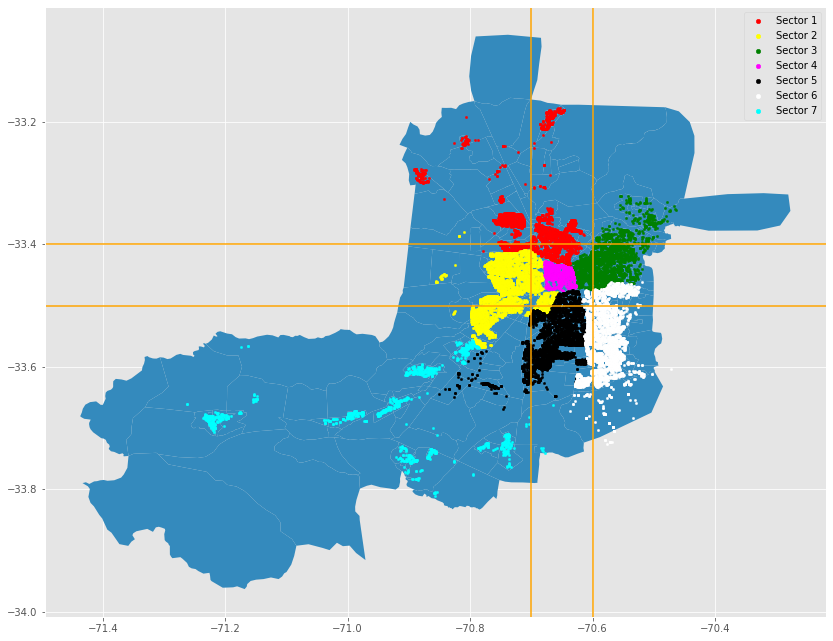

In [30]:
# Read the zones info to be able to clearly visualize the area
zones = gpd.read_file('zone_shapefiles/ZonasEOD2012.shp')

# WE NEED TO CONVERT THE COORDINATES OF THE SHAPE FILE INTO LAT LONG TO BE ABLE TO PLOT DATASETS TOGETHER
# https://stackoverflow.com/questions/47203938/convert-the-coordinates-of-a-shapefile-in-geopandas
zones = zones.to_crs(epsg=4326)

# Now we can plot together the different datasets to visualize the sector variable
fig, ax = plt.subplots(figsize=(14,14))

ax.set_aspect('equal')

zones.plot(ax=ax)

data_full_gdf.loc[data_full_gdf.Sector==1].plot(ax=ax, marker='o', color='red', markersize=5, label='Sector 1')
data_full_gdf.loc[data_full_gdf.Sector==2].plot(ax=ax, marker='o', color='yellow', markersize=5, label='Sector 2')
data_full_gdf.loc[data_full_gdf.Sector==3].plot(ax=ax, marker='o', color='green', markersize=5, label='Sector 3')
data_full_gdf.loc[data_full_gdf.Sector==4].plot(ax=ax, marker='o', color='magenta', markersize=5, label='Sector 4')
data_full_gdf.loc[data_full_gdf.Sector==5].plot(ax=ax, marker='o', color='black', markersize=5, label='Sector 5')
data_full_gdf.loc[data_full_gdf.Sector==6].plot(ax=ax, marker='o', color='white', markersize=5, label='Sector 6')
data_full_gdf.loc[data_full_gdf.Sector==7].plot(ax=ax, marker='o', color='cyan', markersize=5, label='Sector 7')
#define area for test set
plt.axhline(y=-33.4, color='orange', linestyle='-')
plt.axhline(y=-33.5, color='orange', linestyle='-')
plt.axvline(x=-70.6, color='orange', linestyle='-')
plt.axvline(x=-70.7, color='orange', linestyle='-')
ax.legend( markerscale=2, fontsize=10)

plt.show();

Now the chosen points of interest can be plotted together with the zones of Santiago de Chile, to see where the POIs lie on the are. It can be seen that alot of the points overlap when plotted on such a small graph, so the attribued plotted last will appear the most prominently. In this instance the restaurants were plotted last to show how concentrated they seem to be in the prediction area.

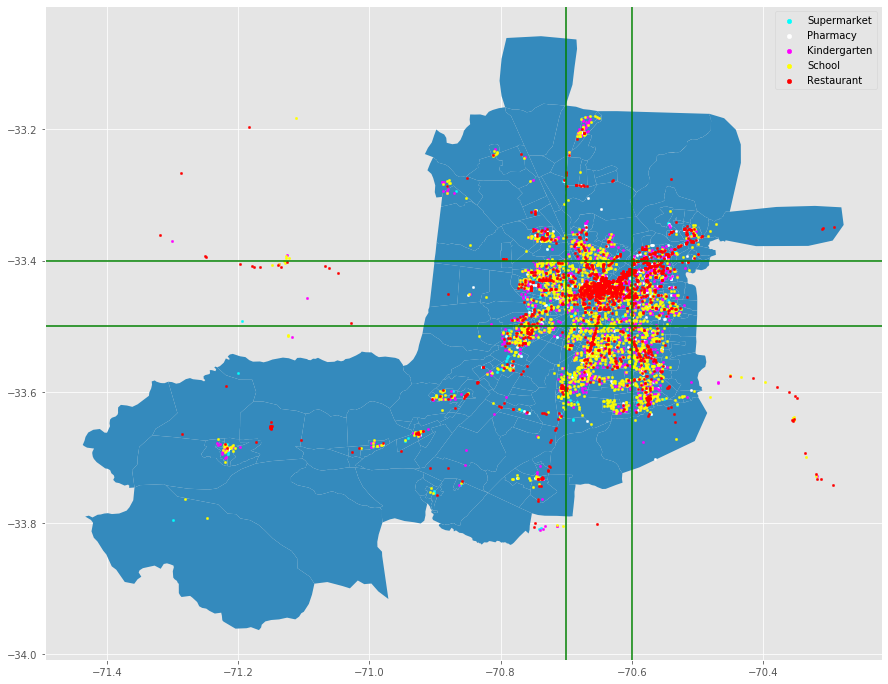

In [31]:
# Now we can plot together the different datasets, the zones and all the points of interest we have chosen

fig, ax = plt.subplots(figsize=(15,15))

ax.set_aspect('equal')

zones.plot(ax=ax)

pois_new.loc[pois_new.fclass=='supermarket'].plot(ax=ax, marker='o', color='cyan', markersize=5, label='Supermarket')
#pois_new.loc[pois_new.fclass=='bank'].plot(ax=ax, marker='o', color='white', markersize=5, label='Bank')
#pois_new.loc[pois_new.fclass=='cafe'].plot(ax=ax, marker='o', color='black', markersize=5, label='Cafe')
#pois_new.loc[pois_new.fclass=='fast_food'].plot(ax=ax, marker='o', color='purple', markersize=5, label='Fast_food')
pois_new.loc[pois_new.fclass=='pharmacy'].plot(ax=ax, marker='o', color='white', markersize=5, label='Pharmacy')
#pois_new.loc[pois_new.fclass=='playground'].plot(ax=ax, marker='o', color='green', markersize=5, label='Playground')
pois_new.loc[pois_new.fclass=='kindergarten'].plot(ax=ax, marker='o', color='magenta', markersize=5, label='Kindergarten')
#pois_new.loc[pois_new.fclass=='convenience'].plot(ax=ax, marker='o', color='cyan', markersize=5, label='Convenience')
pois_new.loc[pois_new.fclass=='school'].plot(ax=ax, marker='o', color='yellow', markersize=5, label='School')
pois_new.loc[pois_new.fclass=='restaurant'].plot(ax=ax, marker='o', color='red', markersize=5, label='Restaurant')

#define area for test set
plt.axhline(y=-33.4, color='g', linestyle='-')
plt.axhline(y=-33.5, color='g', linestyle='-')
plt.axvline(x=-70.6, color='g', linestyle='-')
plt.axvline(x=-70.7, color='g', linestyle='-')

ax.legend( markerscale=2, fontsize=10)

plt.show();

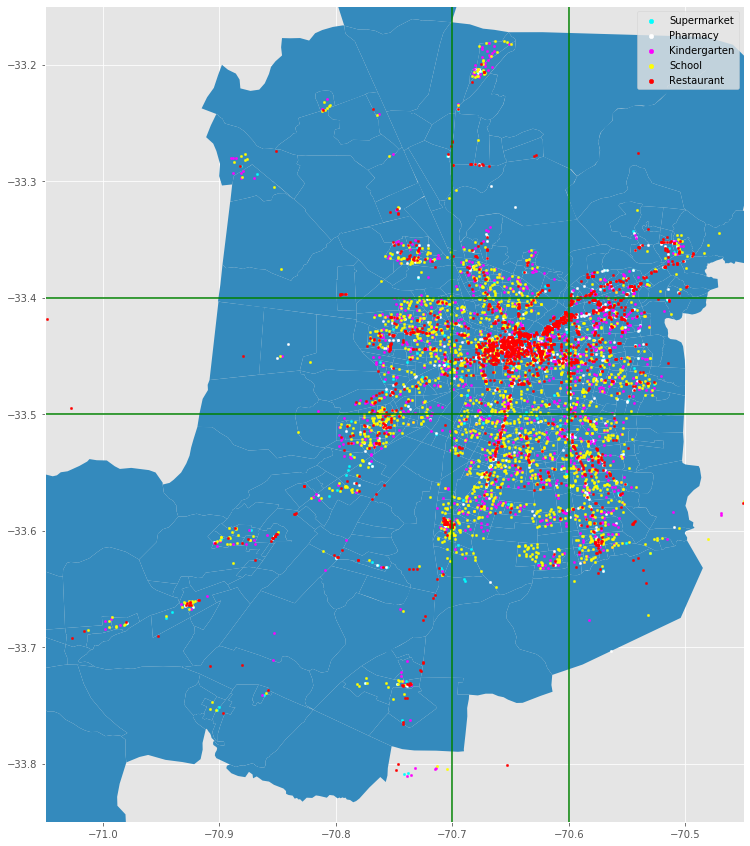

In [32]:
# Now we can plot together the different datasets, the zones and all the points of interest we have chosen

fig, ax = plt.subplots(figsize=(15,15))

ax.set_aspect('equal')

zones.plot(ax=ax)

pois_new.loc[pois_new.fclass=='supermarket'].plot(ax=ax, marker='o', color='cyan', markersize=5, label='Supermarket')
#pois_new.loc[pois_new.fclass=='bank'].plot(ax=ax, marker='o', color='white', markersize=5, label='Bank')
#pois_new.loc[pois_new.fclass=='cafe'].plot(ax=ax, marker='o', color='black', markersize=5, label='Cafe')
#pois_new.loc[pois_new.fclass=='fast_food'].plot(ax=ax, marker='o', color='purple', markersize=5, label='Fast_food')
pois_new.loc[pois_new.fclass=='pharmacy'].plot(ax=ax, marker='o', color='white', markersize=5, label='Pharmacy')
#pois_new.loc[pois_new.fclass=='playground'].plot(ax=ax, marker='o', color='green', markersize=5, label='Playground')
pois_new.loc[pois_new.fclass=='kindergarten'].plot(ax=ax, marker='o', color='magenta', markersize=5, label='Kindergarten')
#pois_new.loc[pois_new.fclass=='convenience'].plot(ax=ax, marker='o', color='cyan', markersize=5, label='Convenience')
pois_new.loc[pois_new.fclass=='school'].plot(ax=ax, marker='o', color='yellow', markersize=5, label='School')
pois_new.loc[pois_new.fclass=='restaurant'].plot(ax=ax, marker='o', color='red', markersize=5, label='Restaurant')

#define area for test set
plt.axhline(y=-33.4, color='g', linestyle='-')
plt.axhline(y=-33.5, color='g', linestyle='-')
plt.axvline(x=-70.6, color='g', linestyle='-')
plt.axvline(x=-70.7, color='g', linestyle='-')

ax.set_xlim([-71.05, -70.45])
ax.set_ylim([-33.85, -33.15])

ax.legend( markerscale=2, fontsize=10)

plt.show();

In order to combine the POIs dataset with the household dataset a function was created to calculate the minimum distance between a given household location and the Points of interest. The function compares the location of each household with the locations of all of the points of interest and outputs the lowest distance. That way it can be seen how far the household would have to travel (direct airline) to get to the nearest type of point of interest, for example the nearest restaurant. Additionally it was thought to be interesting to also compute the number of Points of interest within a 5km distance from the household. That way a better sense could be made of the differences between the geographic locations of different households.

In order to achive this one assumtion had to be made. Since the points are provided in Lat-Long format the **distance.distance** function from the **geopy package** should have been used. It takes into account the Lat-Long positions and the shape of the earth and calculates the distance with the exact degrees needed for that Lat-Long position. That distance measure is a lot more computationally heavy than calculating a simple distance. Since all of the points are located in a similar area the simple distances were computed between all the points, the minimum distance found and then for that single point the geodesic distance (in km) was calculated. Otherwise the function could not have been run on the dataset in this way without additional computational power. It is also assumed here that a simple distance of 0.05 is roughly equal to 5 km, that parameter is used to count the number of POIs in a close radius to the household. The same applies, the distance would have been computed using **distance.distance** if that would have been computationally possible.

In [33]:
# Create a function that returns a column with min distances for two geo data frames.
# Returns min_distance column in KILOMETERS, and counter column in a panda Series
def min_dist(gdf, pois_gdf):

    new_col = [];
    min_dist = 100;
    c_col = [];
    c = 0;

    for point in gdf.geometry: # For each point of gdf points
        for pois in pois_gdf.geometry: # For each point of interest
            
            # Remember that lat = y, long = x, the distance function input should be latitude, longitude
            dist = point.distance(pois) # version calculating distance in diff. lat/long not kilometers
            
            # Using the distance.distance to calculate all distances in km takes AGES (20+ min for one column) to run.
            # For our sanity we assume that the min Lat/Long difference distance in also the min km distance.
            # dist = distance.distance([point.y, point.x], [pois.y, pois.x]).kilometers # Need to adjust the input into the function from the geopoint
            if (dist < min_dist):
                min_dist = dist
                p = pois
                if(dist < 0.05): # if the lat/long distance is less than 0.05 (roughly 5 km) then increase counter
                    c+=1
        # Add the distance to the column. Calculate the final min distance in km for the point with the min distance
        min_dist_km = distance.distance([point.y, point.x], [p.y, p.x]).kilometers
        new_col.append(min_dist_km)
        c_col.append(c)
        # reset min_dist and counter
        min_dist = 100
        c = 0
    
    return pd.Series([new_col, c_col])

Now the function is run on the different types of points of interest, to generate the columns from the dataset that will be used in the modelling later on.

**Since running the next cell takes a long time, the results were saved into a .csv file so that the data could be loaded quickly in the main notebook.**

In [34]:
#########################################################################
## TAKES AT LEAST 3-4 MIN TO RUN ******FOR EACH COLUMN******* SO BE AWARE
#########################################################################

## Create new columns and calculate min distance to pois and number of poins in 5km radius

data_full_gdf['Nearest_Restaurant_km'], data_full_gdf['Nr_Restaurants_5km'] = min_dist(data_full_gdf, pois_new.loc[pois_new.fclass=='restaurant'])

data_full_gdf['Nearest_School_km'], data_full_gdf['Nr_Schools_5km'] = min_dist(data_full_gdf, pois_new.loc[pois_new.fclass=='school'])

data_full_gdf['Nearest_Kindergarten_km'], data_full_gdf['Nr_Kindergartens_5km'] = min_dist(data_full_gdf, pois_new.loc[pois_new.fclass=='kindergarten'])

data_full_gdf['Nearest_Pharmacy_km'], data_full_gdf['Nr_Pharmacies_5km'] = min_dist(data_full_gdf, pois_new.loc[pois_new.fclass=='pharmacy'])

data_full_gdf['Nearest_Supermarket_km'], data_full_gdf['Nr_Supermarkets_5km']  = min_dist(data_full_gdf, pois_new.loc[pois_new.fclass=='supermarket'])

## save the dataframe into a csv so that we don't have to run this every time we run the notebook
data_full_gdf.to_csv('combined_data.csv', index=False)

In [35]:
# Reload the data from the previous cell
data_again = pd.read_csv("combined_data.csv")
data_again.head()

,Hogar,Sector,DirCoordX,DirCoordY,MontoArr,IngresoHogar,Factor,AnosEstudio,CLASE,Sup_Prom_Constr_Hab_EOD,...,Nearest_Restaurant_km,Nr_Restaurants_5km,Nearest_School_km,Nr_Schools_5km,Nearest_Kindergarten_km,Nr_Kindergartens_5km,Nearest_Pharmacy_km,Nr_Pharmacies_5km,Nearest_Supermarket_km,Nr_Supermarkets_5km
0,100010,7,335180.8019,-3733579.025,100000,450845,136.393738,11,1,53.8,...,3.372086,2,0.428810,3,3.291016,1,0.401852,3,0.382922,2
1,100020,7,338410.2114,-3734392.859,120000,1019369,73.843597,11,1,59.6,...,0.494472,4,0.441469,3,0.931185,2,0.545372,2,0.641999,2
2,100030,7,327863.8248,-3742199.914,70000,80000,180.722809,10,1,59.5,...,6.489347,0,7.423389,0,7.173717,0,11.434518,0,7.192890,0
3,100041,7,327864.0000,-3742200.000,80000,559259,150.379059,14,2,59.5,...,6.489515,0,7.423479,0,7.173814,0,11.434464,0,7.192984,0
4,100052,7,338480.8152,-3732703.059,117771,710309,122.001518,12,2,43.6,...,1.153784,4,0.765914,5,0.077181,2,1.161782,4,0.880952,2


Now the results from the combined dataframe can be explored, to get a sense of how the POIs are distributed among the different sectors.

The first plot created is a histogram of the number of restaurants within a 5 km distance from each household, just to see if 5km was a good line to draw, or if this distance should be increased or decreased.

From the histogram below it appears that 5km is a good threshold, where the max number of restaurants is around 20 and the mean is around 6 restaurants.

6.314862591138531


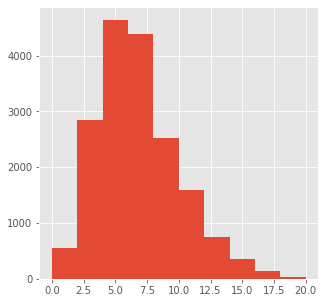

In [36]:
data_again.Nr_Restaurants_5km.hist(figsize=(5,5))
print(data_again.Nr_Restaurants_5km.mean())

Using the combined dataset the **Sector** can be grouped to see the average number of restaurants within a 5km distance for each sector. As the results indicate the average is considerably higher in sector 4, which would seem to correspond with the graph plotted earlier where Sector 4 has a high concentration of restaurants.

In [37]:
data_again.groupby('Sector').Nr_Restaurants_5km.mean() 

Sector
1     6.668795
2     6.993003
3     7.148148
4    10.635342
5     5.230137
6     5.713774
7     3.264798
Name: Nr_Restaurants_5km, dtype: float64

It can also be seen that the average distance to the closest resturants in kilometers is considerably lower for Sector 4 than the other sectors. This combined with the information from the cell above, seems to indicate that when it comes to information about restaurants, Sector 4 is very different from the other sectors, and perhaps it will be more of a challenge to predict for that sector if no training data from the sector is to be provided to the models. 

In [38]:
data_again.groupby('Sector').Nearest_Restaurant_km.mean()

Sector
1    0.698419
2    0.564706
3    0.369033
4    0.134782
5    0.803895
6    0.729285
7    1.096469
Name: Nearest_Restaurant_km, dtype: float64

If the same analysis is done with all the different POIs it can be seen that Sector 4 is the sector that always has the closest average distance to a point of interest. This is not surprising since POIs are concentrated in Sector 4 and it covers less area than the other sectors. Sector 7 appears to be the most suburban area with average distances to POIs considerably higher than most of the other sectors. All of the results can be seen in the following matrix.

In [39]:
# All additional columns
all_columns = ['Nr_Restaurants_5km', 'Nr_Schools_5km', 'Nr_Kindergartens_5km', 'Nr_Pharmacies_5km', 'Nr_Supermarkets_5km', 'Nearest_Restaurant_km', 'Nearest_School_km','Nearest_Kindergarten_km', 'Nearest_Pharmacy_km', 'Nearest_Supermarket_km']

# Group together the columns containing the number of POIs within 5 km distance
nr_columns = ['Sector', 'Nr_Restaurants_5km', 'Nr_Schools_5km', 'Nr_Kindergartens_5km', 'Nr_Pharmacies_5km', 'Nr_Supermarkets_5km']

# Group together the columns containing the nearest POIs.
nearest_columns = ['Sector', 'Nearest_Restaurant_km', 'Nearest_School_km','Nearest_Kindergarten_km', 'Nearest_Pharmacy_km', 'Nearest_Supermarket_km']

# Show a heatmap containing the average distance to nearest POI for each sector and POI type
data_again[nearest_columns].groupby('Sector').mean().style.background_gradient(cmap='coolwarm', axis=0)

,Nearest_Restaurant_km,Nearest_School_km,Nearest_Kindergarten_km,Nearest_Pharmacy_km,Nearest_Supermarket_km
Sector,,,,,
1,0.698419,0.361904,0.402842,1.47861,1.24988
2,0.564706,0.33497,0.433124,0.63349,1.02515
3,0.369033,0.441262,0.405854,0.443074,0.673618
4,0.134782,0.234952,0.307504,0.249792,0.413994
5,0.803895,0.327337,0.399917,1.04766,1.17889
6,0.729285,0.454952,0.474413,0.768715,1.21197
7,1.09647,0.846338,1.13819,2.52298,1.20782


In [40]:
# Show a heatmap containing the average number of POIs within 5km for each sector and type
data_again[nr_columns].groupby('Sector').mean().style.background_gradient(cmap='coolwarm', axis=0)

,Nr_Restaurants_5km,Nr_Schools_5km,Nr_Kindergartens_5km,Nr_Pharmacies_5km,Nr_Supermarkets_5km
Sector,,,,,
1,6.66879,12.3851,6.13887,4.74501,3.28771
2,6.993,11.254,7.03122,4.81109,3.48493
3,7.14815,8.56255,5.81152,6.01193,4.1428
4,10.6353,10.1685,7.61593,7.28703,4.78652
5,5.23014,11.3297,7.07854,4.57869,3.24992
6,5.71377,10.0559,7.24242,4.69118,3.27355
7,3.2648,3.18458,2.45872,2.03037,2.18847


From the above matrix it can be seen that in regards of the number of POIs in the close radius of the household, the concentration of most POIs is higher for households in Sector 4, with the expection of schools where the highest number of them are concentrated around household in Sector 1.

These columns containing the additional information about Points of Interest will be added to the provided dataset and used in later notebooks.